<a href="https://colab.research.google.com/github/mlvlab/vision-tutorial/blob/master/6_Multiple_Object_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multiple Object Tracking with PyTorch**



---
**Reference**


*   Object Detection with Faster R-CNN: https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/ 
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking: https://arxiv.org/abs/1602.00763


**Question**
: What is Multiple Object Tracking?
- Object tracking is one of the tasks in computer vision, which is detecting an object and searching for that object in a video or a series of images (actually both meaning the same thing). 
- Surveillance cameras in public places for spotting suspicious activities or crimes, and a computer system called 'Hawk-eye' for tracking the trajectory of the ball in various sports are typical examples of applying object tracking in a real life.


**Goals**


1. We will use MOT17Det Dataset
2. First part: Object Detection with **Faster R-CNN**
3. Second part: Multiple Object(ID) Tracking with  **Simple Online and Realtime Tracking (SORT)** algorithm



---




In [1]:
# re-install scikit-image
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image
!pip uninstall imgaug
!pip install imgaug
!pip install -U scikit-image
import skimage
print(skimage.__version__)


0.15.0




**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   We will only use MOT17-09 dataset for our task.


---






In [0]:
# Download MOT17Det Dataset

!wget https://motchallenge.net/data/MOT17Det.zip
!unzip MOT17Det.zip

In [0]:
# we will use only MOT17-09 dataset
import sys

motdata = 'train/MOT17-09/img1/'
sys.path.append(motdata)

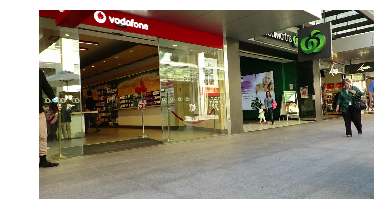

In [4]:
# Example: Original picture before detection
import os
import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.





---




In [0]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [0]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [0]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [0]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [0]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [0]:
# Example: After detection
object_detection_api(img_ex_path,threshold=0.8)





*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.






---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [11]:
# Git clone: SORT Algorithm

!git clone https://github.com/abewley/sort.git
  

Cloning into 'sort'...
remote: Enumerating objects: 135, done.
remote: Total 135 (delta 0), reused 0 (delta 0), pack-reused 135
Receiving objects: 100% (135/135), 1.19 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [0]:
# requirement for sort
!cd sort;pip install -r requirements.txt

In [13]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!git clone https://github.com/mlvlab/vision-tutorial.git

Cloning into 'vision-tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 64 (delta 34), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [0]:
import json
import collections
from pprint import pprint

jsonpath = 'vision-tutorial/6_MOT_detinfo.json'

with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [0]:
# Let's check out downloaded json file

pprint(odata['000001.jpg'])



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ 



---



In [0]:
# Making new directory for saving results
save_path = 'save/'
!mkdir "{save_path}"

In [0]:
sys.path.append('sort/')
from sort import *

In [0]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [0]:
img_path = motdata
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)


---
It's all done!


*   Finally, you can get a sequence of image with each Tracking ID for every detected person. 
*   Check '3_MOT_result.gif' for whole demo experience.



---


